<a href="https://colab.research.google.com/github/JoaoLucasAbreu/Forecasting_Data/blob/main/Time_Series/Sales_Season.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seasonality

We say that a time series exhibits seasonality whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times.



## Seasonal Plots and Seasonal Indicators

Just like we used a moving average plot to discover the trend in a series, we can use a seasonal plot to discover seasonal patterns.

A seasonal plot shows segments of the time series plotted against some common period, the period being the "season" you want to observe.

In [1]:
pip install statsmodels==0.13.0

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [33]:
holidays_df = pd.read_csv('/content/drive/MyDrive/csv_files/holidays_events.csv',
                          dtype={
                            'type': 'category',
                            'locale': 'category',
                            'locale_name': 'category',
                            'description': 'category',
                            'transferred': 'bool',
                          },
                            parse_dates=['date'],
                            infer_datetime_format=True,
                  )

holidays_df = holidays_df.set_index('date').to_period('D')

sales_df = pd.read_csv('/content/drive/MyDrive/csv_files/train.csv',
                       usecols=['store_nbr', 'family', 'date', 'sales'],
                       dtype={
                        'store_nbr': 'category',
                        'family': 'category',
                        'sales': 'float32',
                      },
                        parse_dates=['date'],
                        infer_datetime_format=True,
                  )

sales_df['date'] = sales_df.date.dt.to_period('D')

sales_df = sales_df.set_index(['store_nbr', 'family', 'date']).sort_index()


average_sales = (sales_df.groupby('date').mean().squeeze().loc['2017'])

In [43]:
def seasonal_plot(X, y, period, freq, ax=None):
    
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette(
        "husl",
        n_colors=X[period].nunique(),
    )
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [60]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [81]:
plot_params = {
 'color': '0.2',
 'style': '.-',
 'markeredgecolor': '0.25',
 'markerfacecolor': '0.25',
 'legend': False}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  from ipykernel import kernelapp as app
No handles with labels found to put in legend.


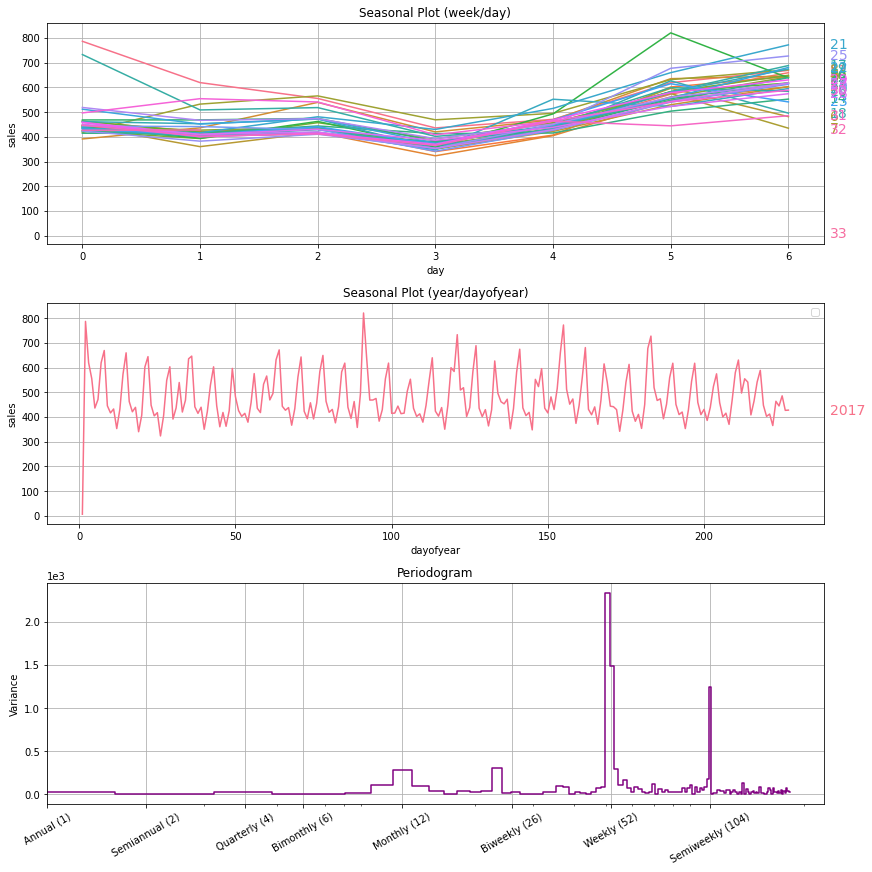

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

In [92]:
X = average_sales.to_frame()
# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 12), constrained_layout = True)
ax0.set_title("Seasonal Plot (week/day)")
ax1.set_title("Seasonal Plot (year/dayofyear)")
ax2.set_title("Periodogram")
seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1)
plot_periodogram(average_sales, ax=ax2)
ax0.grid(True)
ax1.grid(True)
ax2.grid(True)

The periodogram agrees with the seasonal plots above: a strong weekly and semiweekly season and a weaker annual season. The weekly season we'll model with indicators and the annual season with Fourier features. From right to left, the periodogram falls off between Bimonthly (6) and Monthly (12), so let's use 10 Fourier pairs.

## Seasonal Features

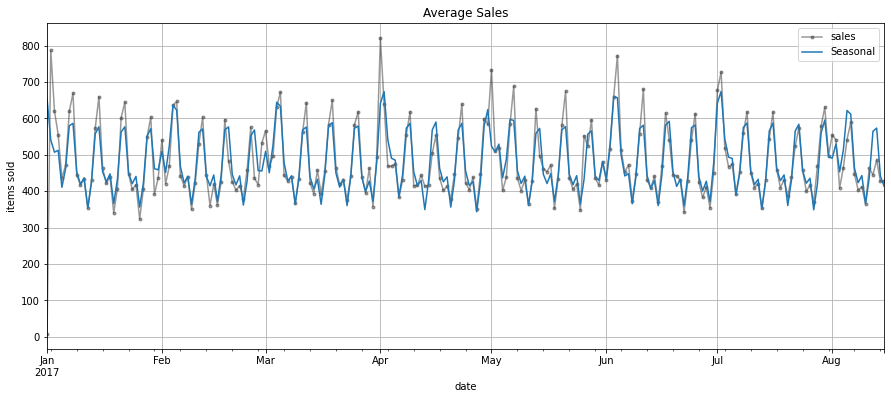

In [95]:
y = average_sales.copy()

fourier = CalendarFourier(freq="M", order = 4)  # 4 sin/cos pairs for "M"onthly seasonality

dp = DeterministicProcess(
    index=y.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # Monthly seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()

model = LinearRegression().fit(X, y)

y_pred = pd.Series(model.predict(X), index = X.index)

plt.figure(figsize = (15, 6))

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.grid(True)
ax.legend();

## Holiday Feature

What kind of features could you create to help your model make use of this information?

In [103]:
holidays = (
    holidays_df
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


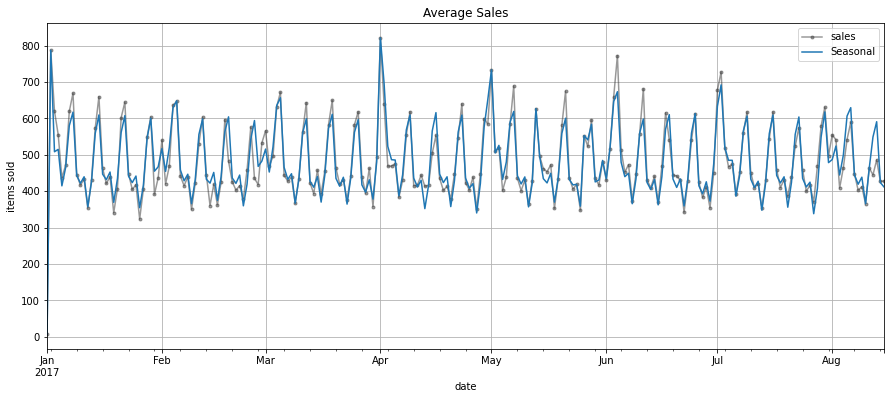

In [105]:
X_holidays = pd.get_dummies(holidays)

X2 = X.join(X_holidays, on='date').fillna(0.0)

model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
plt.figure(figsize = (15, 6))
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.grid(True)
ax.legend();

## 90-day forecast

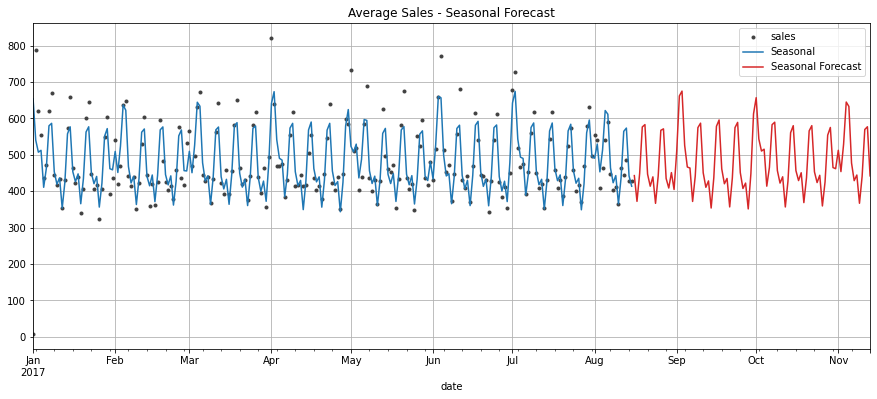

In [113]:
y = average_sales.copy()
y = average_sales.to_frame()

y = y['sales']

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

plt.figure(figsize = (15, 6))
ax = y.plot(color='0.25', style='.', title="Average Sales - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
ax.grid(True)
_ = ax.legend()